In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
dim_reduced_df = pd.read_csv('../data/feature-engineered/df_2_reduced.csv')

In [4]:
# -----------------------------
# CONFIG
# -----------------------------
financial_indicators = [
    '1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', 
    '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 
    'OECD_CLI_index', 'CSI_index', 'gdp_per_capita'
]

recession_targets = [
    'recession_probability', '1_month_recession_probability',
    '3_month_recession_probability', '6_month_recession_probability'
]

# -----------------------------
# DATA SPLIT
# -----------------------------
def prepare_data_split(df, date_col='date', split_year=2020):
    df[date_col] = pd.to_datetime(df[date_col])
    df_sorted = df.sort_values(date_col).reset_index(drop=True)
    train_data = df_sorted[df_sorted[date_col].dt.year < split_year].copy()
    test_data = df_sorted[df_sorted[date_col].dt.year >= split_year].copy()
    print(f"Training: {len(train_data)} rows | Testing: {len(test_data)} rows")
    return train_data, test_data

# -----------------------------
# FIXED PROPHET FORECAST FUNCTION
# -----------------------------
def forecast_with_prophet_fixed(train_df, test_df, target, exog_cols=None):
    print(f"\n{'='*50}")
    print(f"Prophet Forecasting: {target}")
    print(f"{'='*50}")

    # Check if target exists
    if target not in train_df.columns:
        print(f"❌ Target {target} not found in training data")
        return None, None, None, None, None, None

    # -----------------------------
    # Prepare base training and test data
    # -----------------------------
    train = train_df[['date', target]].copy()
    train.columns = ['ds', 'y']
    test = test_df[['date', target]].copy()
    test.columns = ['ds', 'y']

    # Clean target data
    train.replace([np.inf, -np.inf], np.nan, inplace=True)
    test.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Remove rows where target is NaN
    train = train.dropna()
    test = test.dropna()

    if len(train) < 10:
        print(f"❌ Insufficient training data for {target}: {len(train)} rows")
        return None, None, None, None, None, None

    print(f"✓ Clean data: {len(train)} train, {len(test)} test rows")

    # -----------------------------
    # Initialize Prophet model
    # -----------------------------
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.01,
        seasonality_prior_scale=10,
        holidays_prior_scale=10,
        seasonality_mode='additive'
    )

    # -----------------------------
    # Add exogenous regressors BEFORE fitting
    # -----------------------------
    valid_exog_cols = []
    if exog_cols:
        print(f"Processing {len(exog_cols)} potential exogenous features...")
        
        for col in exog_cols:
            if col in train_df.columns:
                # Check data quality for this feature
                train_col_data = train_df[col].replace([np.inf, -np.inf], np.nan)
                test_col_data = test_df[col].replace([np.inf, -np.inf], np.nan)
                
                # Require at least 70% non-missing data
                if (train_col_data.notna().sum() / len(train_col_data)) >= 0.7:
                    valid_exog_cols.append(col)
                    model.add_regressor(col, prior_scale=10, standardize=True)
                    
        print(f"✓ Added {len(valid_exog_cols)} valid exogenous regressors")

    # -----------------------------
    # Merge exogenous data if we have valid features
    # -----------------------------
    if valid_exog_cols:
        # Prepare exogenous data
        train_exog = train_df[['date'] + valid_exog_cols].copy()
        test_exog = test_df[['date'] + valid_exog_cols].copy()
        
        # Clean exogenous data
        for col in valid_exog_cols:
            train_exog[col] = train_exog[col].replace([np.inf, -np.inf], np.nan)
            test_exog[col] = test_exog[col].replace([np.inf, -np.inf], np.nan)
            
            # Fill missing values
            train_exog[col] = train_exog[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
            test_exog[col] = test_exog[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
        
        # Rename date column for merging
        train_exog.columns = ['ds'] + valid_exog_cols
        test_exog.columns = ['ds'] + valid_exog_cols
        
        # Merge with inner join to ensure alignment
        train = train.merge(train_exog, on='ds', how='inner')
        test = test.merge(test_exog, on='ds', how='inner')
        
        print(f"✓ After merging: {len(train)} train, {len(test)} test rows")
        
        # Final cleanup
        train = train.dropna()
        test = test.dropna()

    if len(train) < 5:
        print(f"❌ Insufficient data after cleaning: {len(train)} rows")
        return None, None, None, None, None, None

    # -----------------------------
    # Fit Prophet model
    # -----------------------------
    print("🔄 Fitting Prophet model...")
    model.fit(train)

    # -----------------------------
    # Prepare future dataframe for forecasting
    # -----------------------------
    if valid_exog_cols:
        future = test[['ds'] + valid_exog_cols].copy()
    else:
        future = test[['ds']].copy()

    print(f"✓ Forecasting {len(future)} periods...")
    forecast = model.predict(future)

    # -----------------------------
    # Evaluate performance
    # -----------------------------
    y_true = test['y'].values
    y_pred = forecast['yhat'].values[:len(y_true)]  # Ensure same length
    
    # Calculate metrics safely
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # Safe MAPE calculation
    def safe_mape(y_true, y_pred, epsilon=1e-8):
        return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), epsilon))) * 100
    
    mape = safe_mape(y_true, y_pred)

    print(f"📊 Results:")
    print(f"   MAE: {mae:.4f}")
    print(f"   RMSE: {rmse:.4f}")
    print(f"   MAPE: {mape:.2f}%")
    
    # Check if forecast is flat (debugging)
    pred_std = np.std(y_pred)
    if pred_std < 1e-6:
        print("⚠️  WARNING: Forecast appears to be flat!")
        print(f"   Prediction std: {pred_std:.8f}")
        print(f"   Prediction range: {np.min(y_pred):.4f} to {np.max(y_pred):.4f}")
    else:
        print(f"✓ Forecast has variation (std: {pred_std:.4f})")

    return model, forecast, mae, rmse, mape, test

# -----------------------------
# PLOTTING WITH TREND/SEASONALITY
# -----------------------------
def plot_prophet_forecast_detailed(model, forecast, test, target):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Main forecast plot
    ax1 = axes[0, 0]
    ax1.plot(test['ds'], test['y'], label='Actual', color='blue', linewidth=2)
    ax1.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red', linewidth=2)
    ax1.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                     color='pink', alpha=0.3, label='95% CI')
    ax1.set_title(f"{target} - Forecast vs Actual")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Trend component
    ax2 = axes[0, 1]
    if 'trend' in forecast.columns:
        ax2.plot(forecast['ds'], forecast['trend'], label='Trend', color='green')
        ax2.set_title("Trend Component")
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    # Yearly seasonality (if exists)
    ax3 = axes[1, 0]
    if 'yearly' in forecast.columns:
        ax3.plot(forecast['ds'], forecast['yearly'], label='Yearly', color='orange')
        ax3.set_title("Yearly Seasonality")
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    # Residuals
    ax4 = axes[1, 1]
    residuals = test['y'].values - forecast['yhat'].values[:len(test)]
    ax4.scatter(range(len(residuals)), residuals, alpha=0.6)
    ax4.axhline(y=0, color='red', linestyle='--')
    ax4.set_title("Residuals")
    ax4.set_xlabel("Time Index")
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# -----------------------------
# FIXED RUN PIPELINE
# -----------------------------
def run_prophet_pipeline_fixed(df, financial_indicators, include_exog=True, plot_results=True):
    """Fixed pipeline that should produce non-flat forecasts"""
    
    train_data, test_data = prepare_data_split(df)
    all_results = {}

    # Define exogenous variables (exclude targets + financial indicators)
    exog_cols = None
    if include_exog:
        exog_cols = [col for col in df.columns 
                     if col not in financial_indicators + recession_targets + ['date']]
        print(f"🔧 Using {len(exog_cols)} exogenous features")

    successful_forecasts = 0
    failed_forecasts = []

    for indicator in financial_indicators:
        if indicator not in df.columns:
            print(f"⚠️  {indicator} not found in DataFrame")
            failed_forecasts.append(indicator)
            continue

        try:
            result = forecast_with_prophet_fixed(
                train_data, test_data, indicator, exog_cols=exog_cols
            )
            
            model, forecast, mae, rmse, mape, test = result
            
            if model is not None:
                all_results[indicator] = {
                    'model': model, 
                    'forecast': forecast,
                    'mae': mae, 
                    'rmse': rmse, 
                    'mape': mape,
                    'test_data': test
                }
                successful_forecasts += 1

                if plot_results:
                    plot_prophet_forecast_detailed(model, forecast, test, indicator)
            else:
                failed_forecasts.append(indicator)
                
        except Exception as e:
            print(f"❌ Error forecasting {indicator}: {str(e)}")
            failed_forecasts.append(indicator)

    print(f"\n📈 PIPELINE SUMMARY")
    print(f"✅ Successful: {successful_forecasts}")
    print(f"❌ Failed: {len(failed_forecasts)}")
    if failed_forecasts:
        print(f"Failed indicators: {failed_forecasts}")

    return all_results

# -----------------------------
# USAGE
# -----------------------------
# results = run_prophet_pipeline_fixed(
#     dim_reduced_df, 
#     financial_indicators, 
#     include_exog=True, 
#     plot_results=True
# )

/var/folders/vx/lz_s92194473v0lcw_034qq40000gn/T/ipykernel_65200/3898925279.py:108: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_exog[col] = train_exog[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/var/folders/vx/lz_s92194473v0lcw_034qq40000gn/T/ipykernel_65200/3898925279.py:109: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_exog[col] = test_exog[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
20:30:06 - cmdstanpy - INFO - Chain [1] start processing


Training: 635 rows | Testing: 65 rows
🔧 Using 35 exogenous features

Prophet Forecasting: 1_year_rate
✓ Clean data: 556 train, 65 test rows
Processing 35 potential exogenous features...
✓ Added 34 valid exogenous regressors
✓ After merging: 556 train, 65 test rows
🔄 Fitting Prophet model...


20:30:07 - cmdstanpy - INFO - Chain [1] done processing


✓ Forecasting 65 periods...
📊 Results:
   MAE: 4.4816
   RMSE: 5.2782
   MAPE: 1101.70%
✓ Forecast has variation (std: 2.8433)


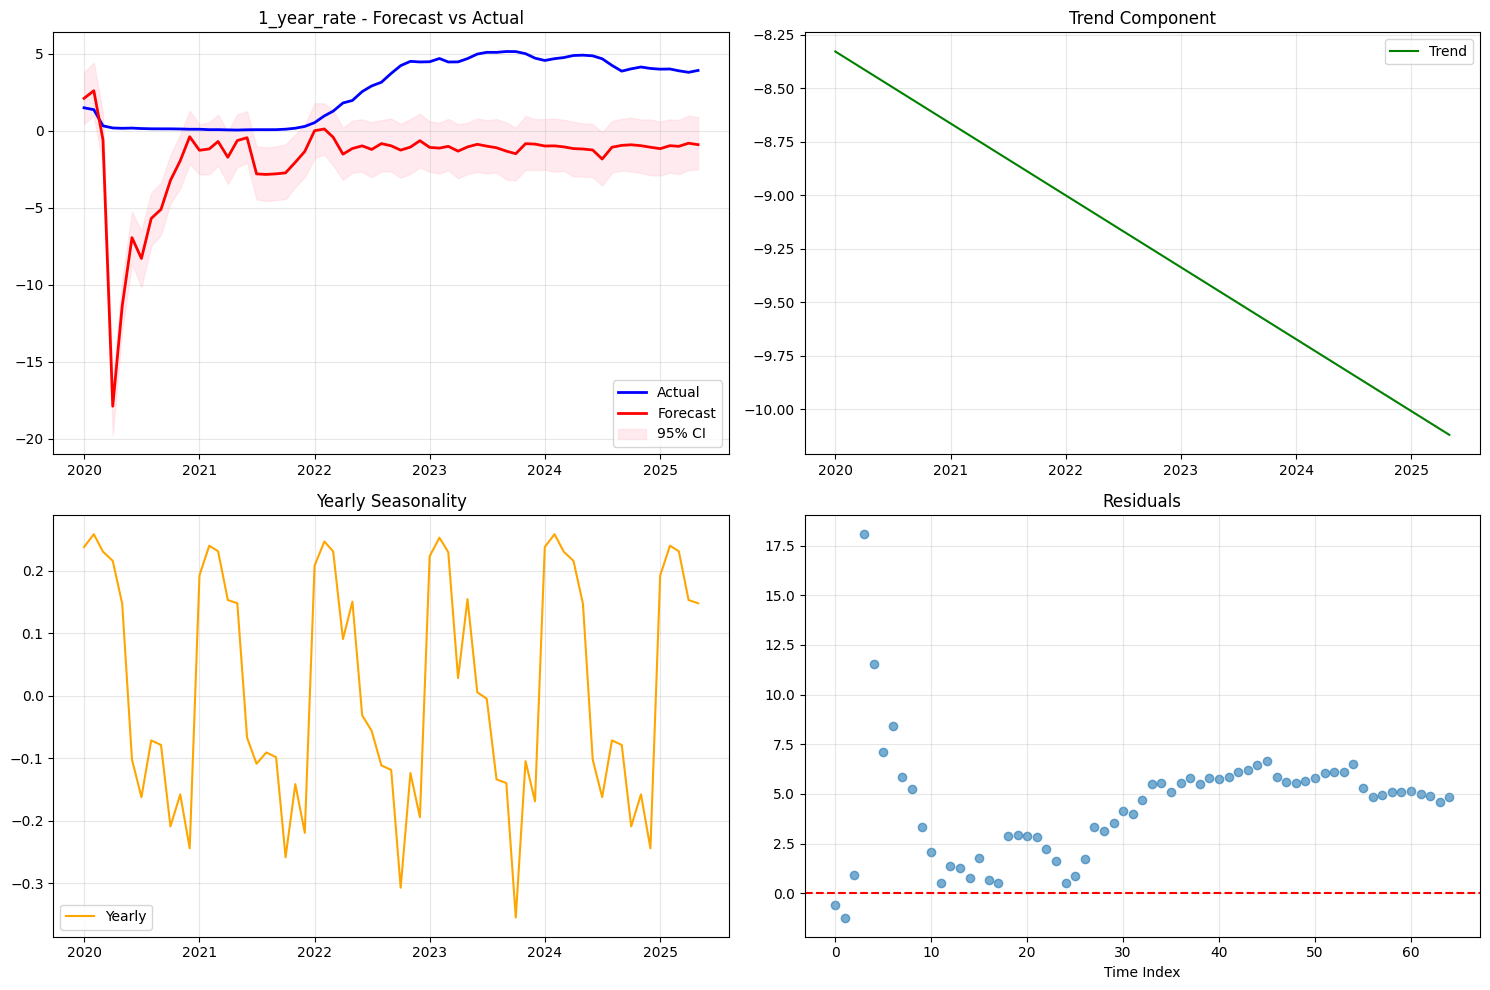

/var/folders/vx/lz_s92194473v0lcw_034qq40000gn/T/ipykernel_65200/3898925279.py:108: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_exog[col] = train_exog[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/var/folders/vx/lz_s92194473v0lcw_034qq40000gn/T/ipykernel_65200/3898925279.py:109: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_exog[col] = test_exog[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
20:30:07 - cmdstanpy - INFO - Chain [1] start processing
20:30:07 - cmdstanpy - INFO - Chain [1] done processing



Prophet Forecasting: 3_months_rate
✓ Clean data: 635 train, 65 test rows
Processing 35 potential exogenous features...
✓ Added 34 valid exogenous regressors
✓ After merging: 635 train, 65 test rows
🔄 Fitting Prophet model...
✓ Forecasting 65 periods...
📊 Results:
   MAE: 2.7757
   RMSE: 3.8402
   MAPE: 1108.68%
✓ Forecast has variation (std: 3.5536)


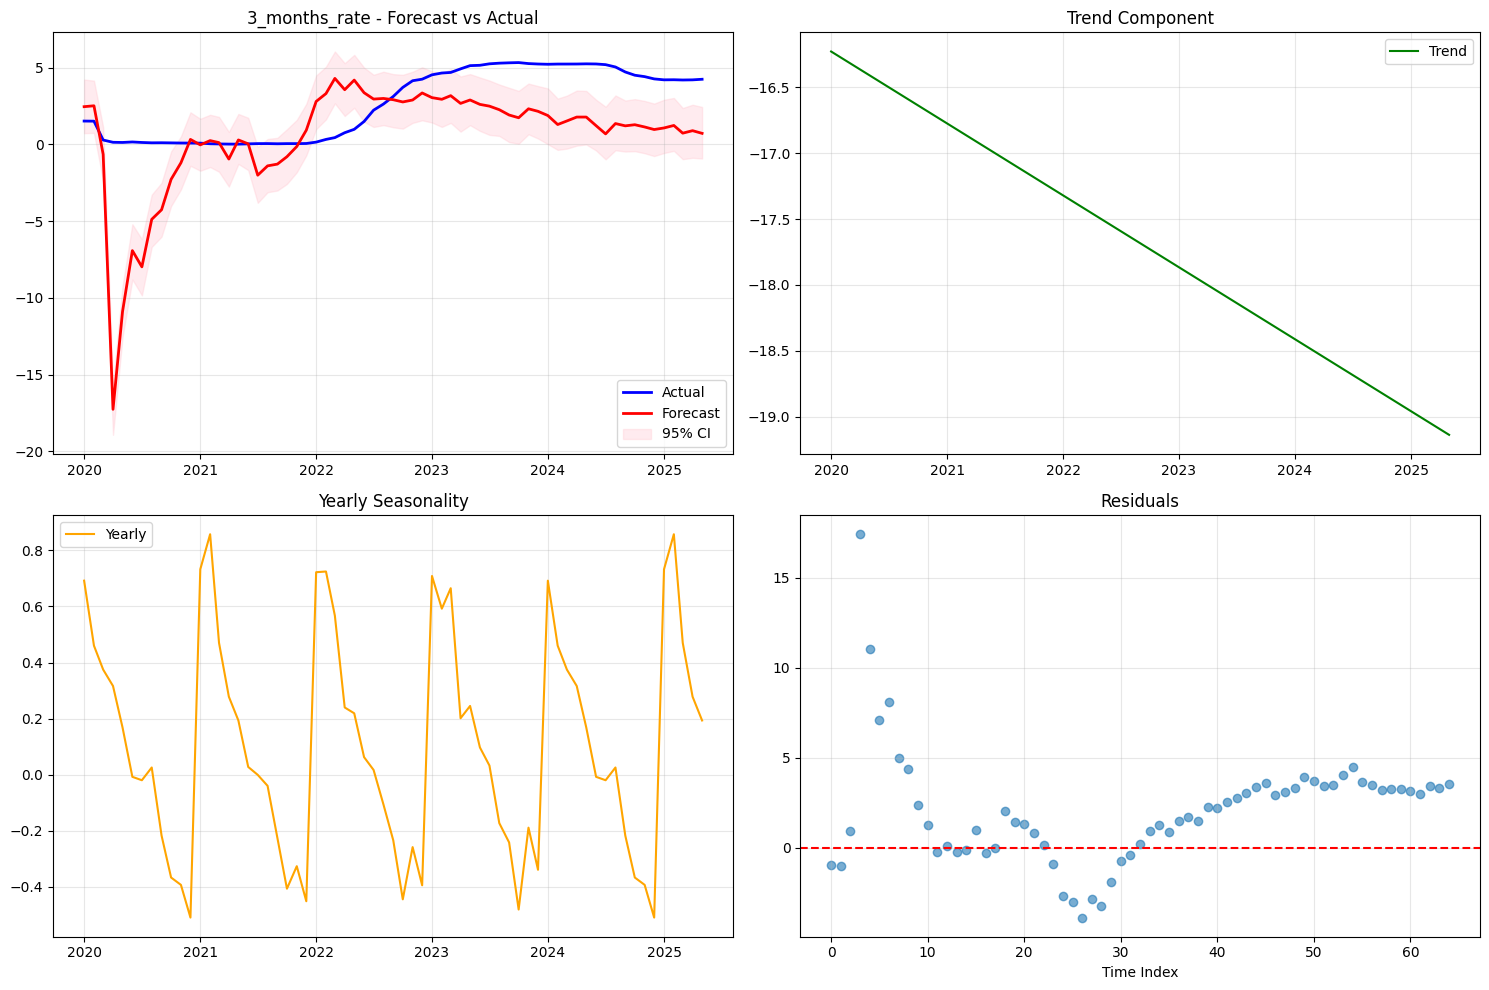

/var/folders/vx/lz_s92194473v0lcw_034qq40000gn/T/ipykernel_65200/3898925279.py:108: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_exog[col] = train_exog[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/var/folders/vx/lz_s92194473v0lcw_034qq40000gn/T/ipykernel_65200/3898925279.py:109: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_exog[col] = test_exog[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
20:30:08 - cmdstanpy - INFO - Chain [1] start processing
20:30:08 - cmdstanpy - INFO - Chain [1] done processing



Prophet Forecasting: 6_months_rate
✓ Clean data: 635 train, 65 test rows
Processing 35 potential exogenous features...
✓ Added 34 valid exogenous regressors
✓ After merging: 635 train, 65 test rows
🔄 Fitting Prophet model...
✓ Forecasting 65 periods...
📊 Results:
   MAE: 2.5695
   RMSE: 3.5732
   MAPE: 800.63%
✓ Forecast has variation (std: 3.4443)


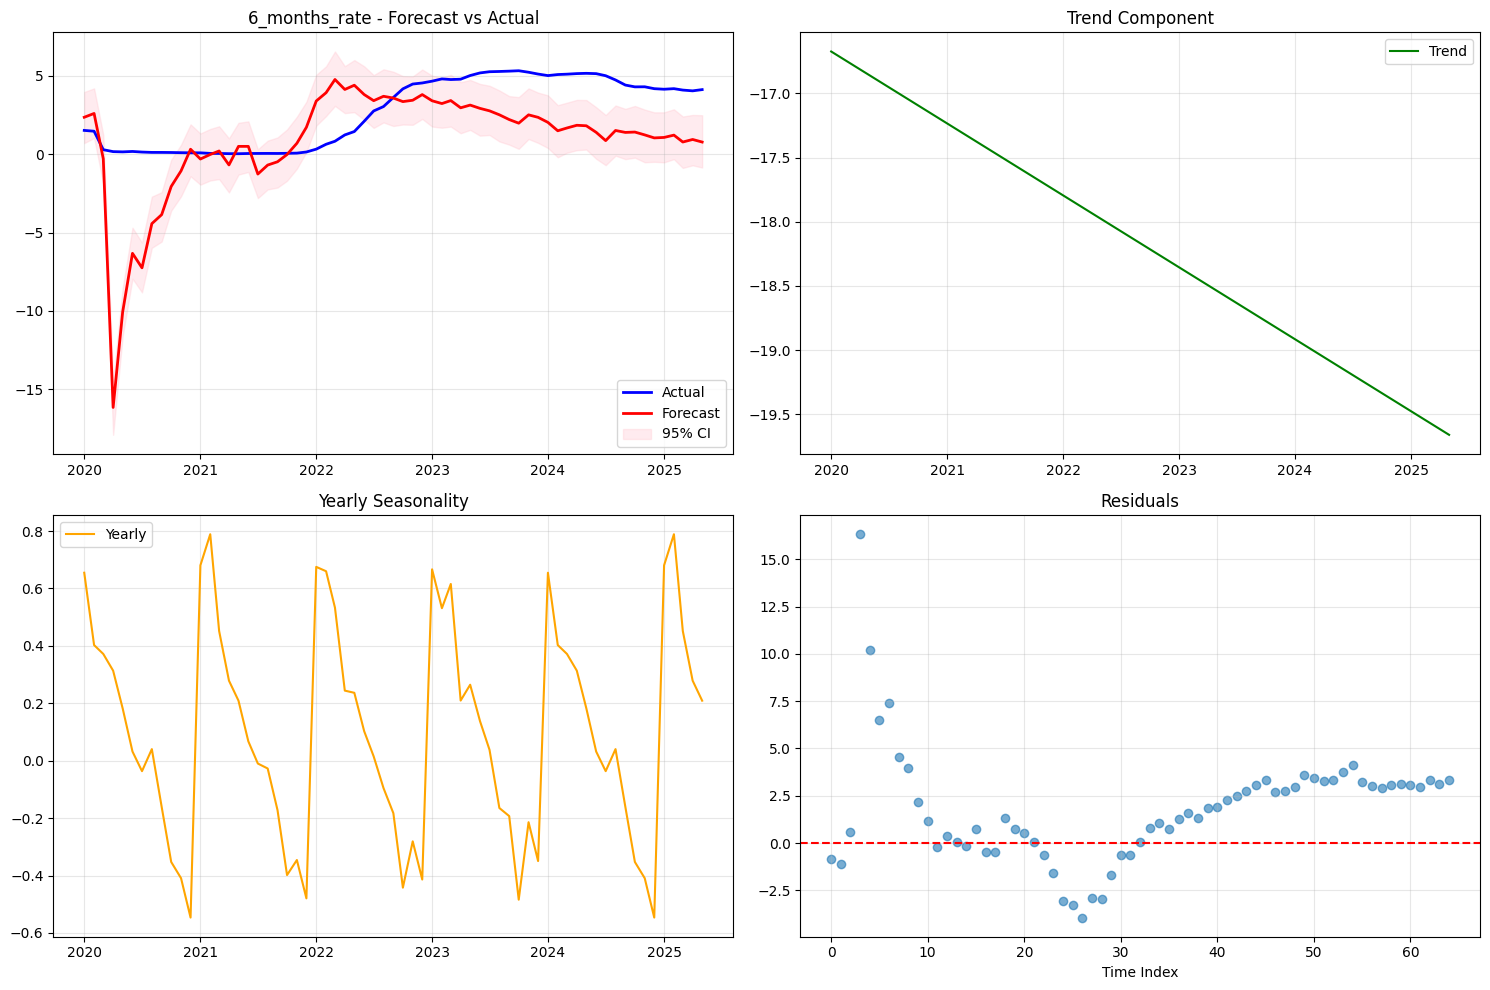

/var/folders/vx/lz_s92194473v0lcw_034qq40000gn/T/ipykernel_65200/3898925279.py:108: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_exog[col] = train_exog[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/var/folders/vx/lz_s92194473v0lcw_034qq40000gn/T/ipykernel_65200/3898925279.py:109: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_exog[col] = test_exog[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
20:30:08 - cmdstanpy - INFO - Chain [1] start processing



Prophet Forecasting: CPI
✓ Clean data: 635 train, 65 test rows
Processing 35 potential exogenous features...
✓ Added 34 valid exogenous regressors
✓ After merging: 635 train, 65 test rows
🔄 Fitting Prophet model...


20:30:09 - cmdstanpy - INFO - Chain [1] done processing


✓ Forecasting 65 periods...
📊 Results:
   MAE: 0.5073
   RMSE: 0.6254
   MAPE: 0.18%
✓ Forecast has variation (std: 21.6607)


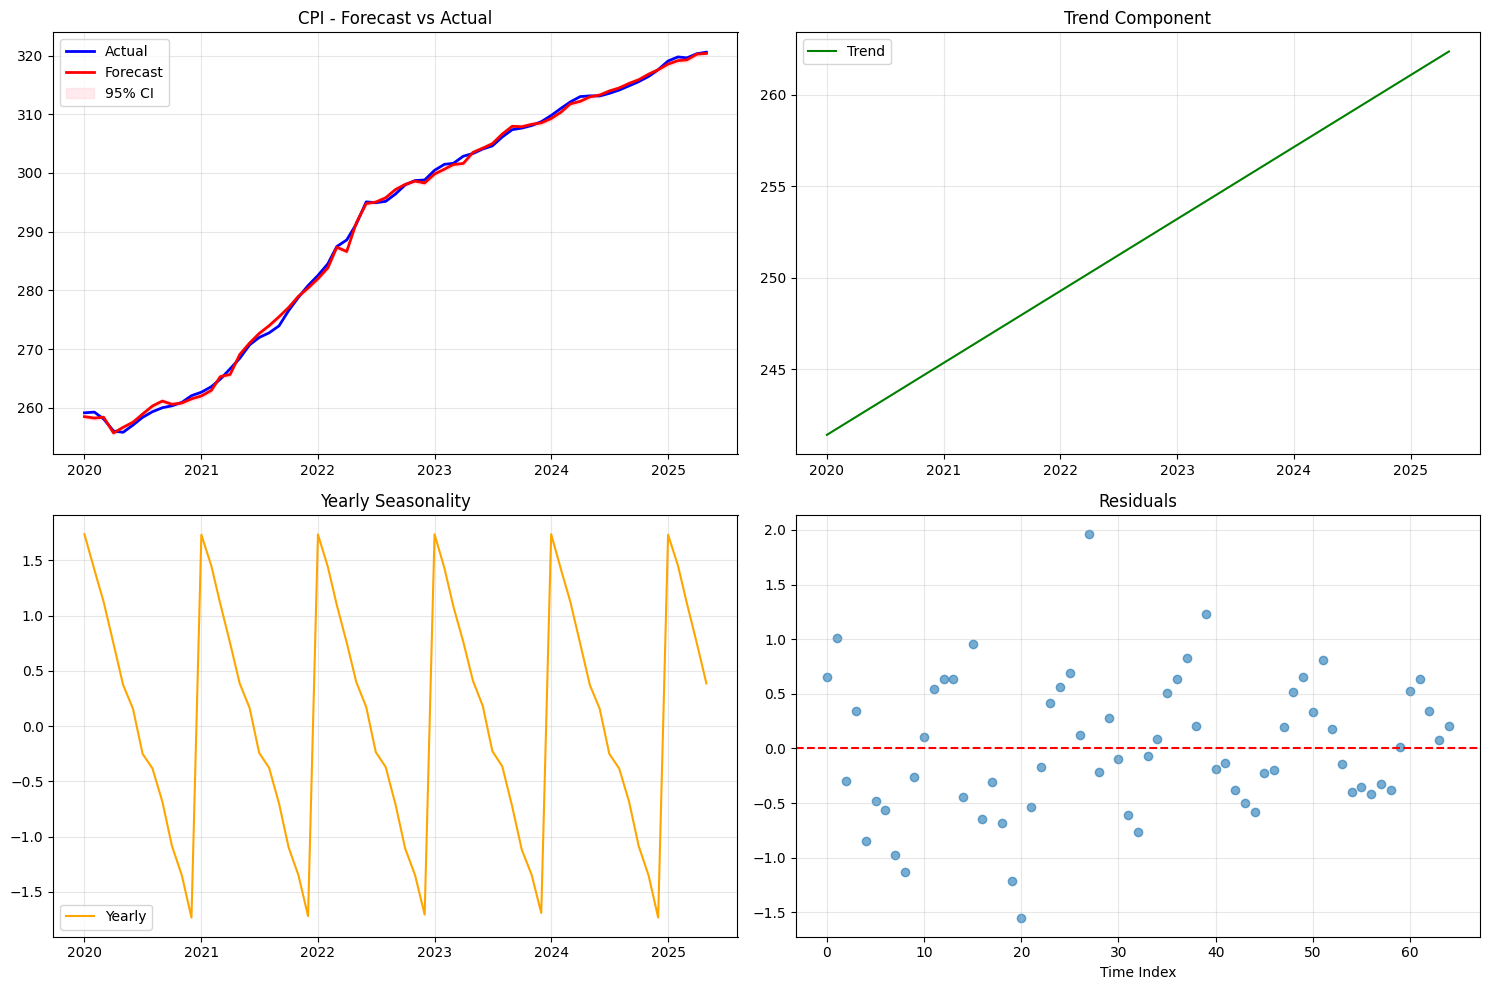

/var/folders/vx/lz_s92194473v0lcw_034qq40000gn/T/ipykernel_65200/3898925279.py:108: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_exog[col] = train_exog[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/var/folders/vx/lz_s92194473v0lcw_034qq40000gn/T/ipykernel_65200/3898925279.py:109: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_exog[col] = test_exog[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
20:30:10 - cmdstanpy - INFO - Chain [1] start processing



Prophet Forecasting: INDPRO
✓ Clean data: 635 train, 65 test rows
Processing 35 potential exogenous features...
✓ Added 34 valid exogenous regressors
✓ After merging: 635 train, 65 test rows
🔄 Fitting Prophet model...


20:30:10 - cmdstanpy - INFO - Chain [1] done processing


✓ Forecasting 65 periods...
📊 Results:
   MAE: 0.2560
   RMSE: 0.3503
   MAPE: 0.26%
✓ Forecast has variation (std: 3.6493)


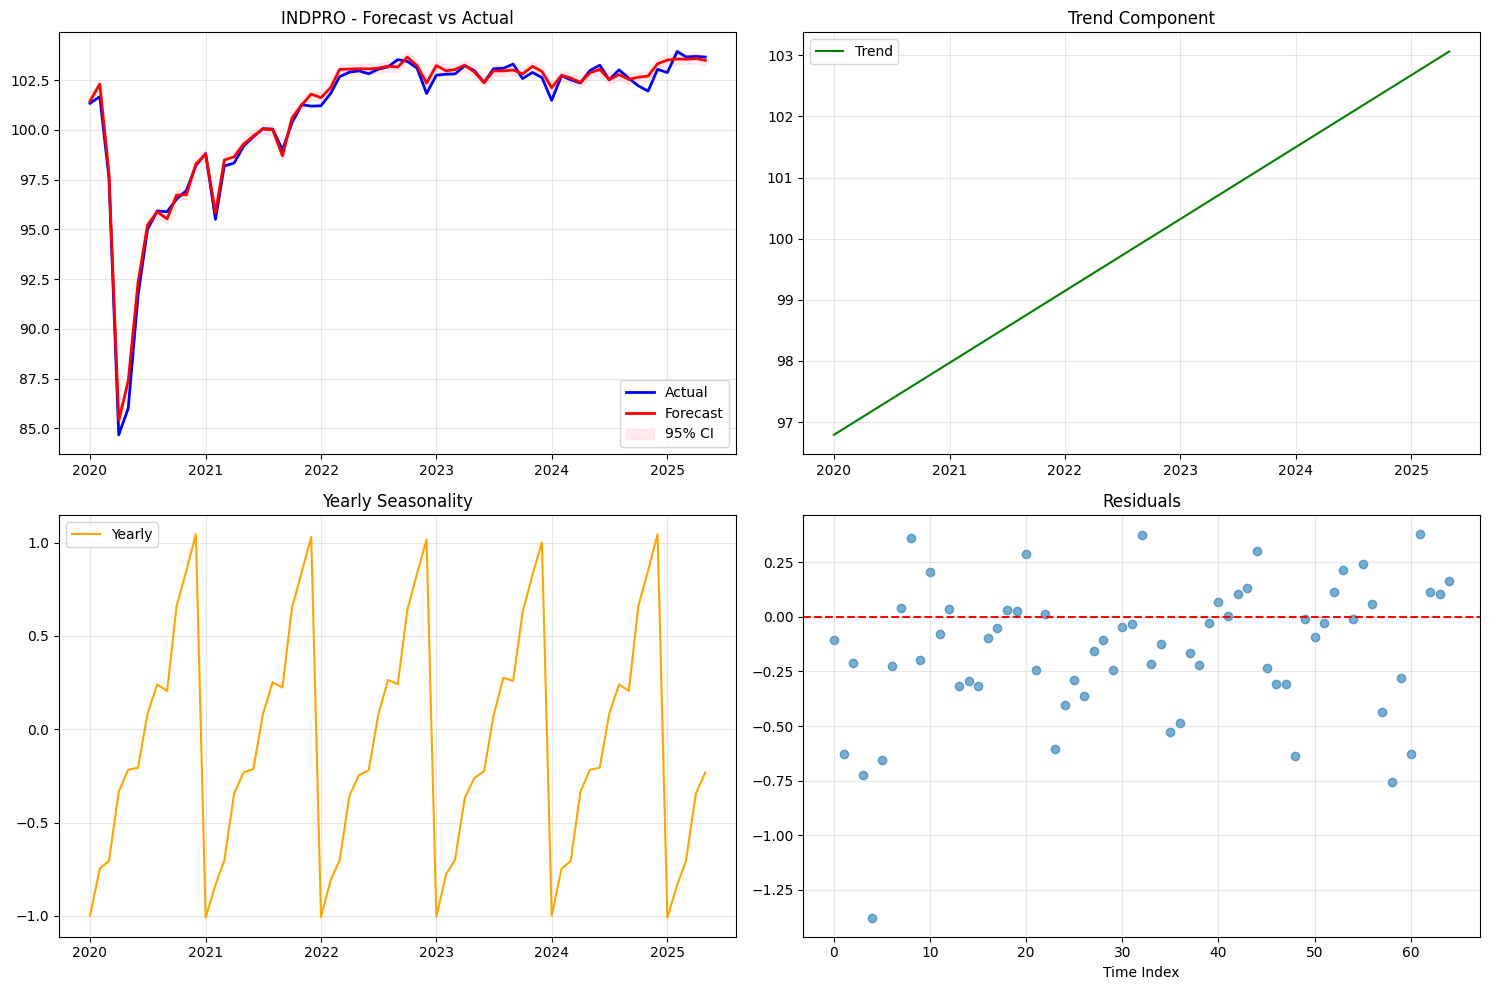

/var/folders/vx/lz_s92194473v0lcw_034qq40000gn/T/ipykernel_65200/3898925279.py:108: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_exog[col] = train_exog[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/var/folders/vx/lz_s92194473v0lcw_034qq40000gn/T/ipykernel_65200/3898925279.py:109: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_exog[col] = test_exog[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
20:30:11 - cmdstanpy - INFO - Chain [1] start processing
20:30:11 - cmdstanpy - INFO - Chain [1] done processing



Prophet Forecasting: 10_year_rate
✓ Clean data: 635 train, 65 test rows
Processing 35 potential exogenous features...
✓ Added 34 valid exogenous regressors
✓ After merging: 635 train, 65 test rows
🔄 Fitting Prophet model...
✓ Forecasting 65 periods...
📊 Results:
   MAE: 1.9674
   RMSE: 2.6989
   MAPE: 130.40%
✓ Forecast has variation (std: 2.3920)


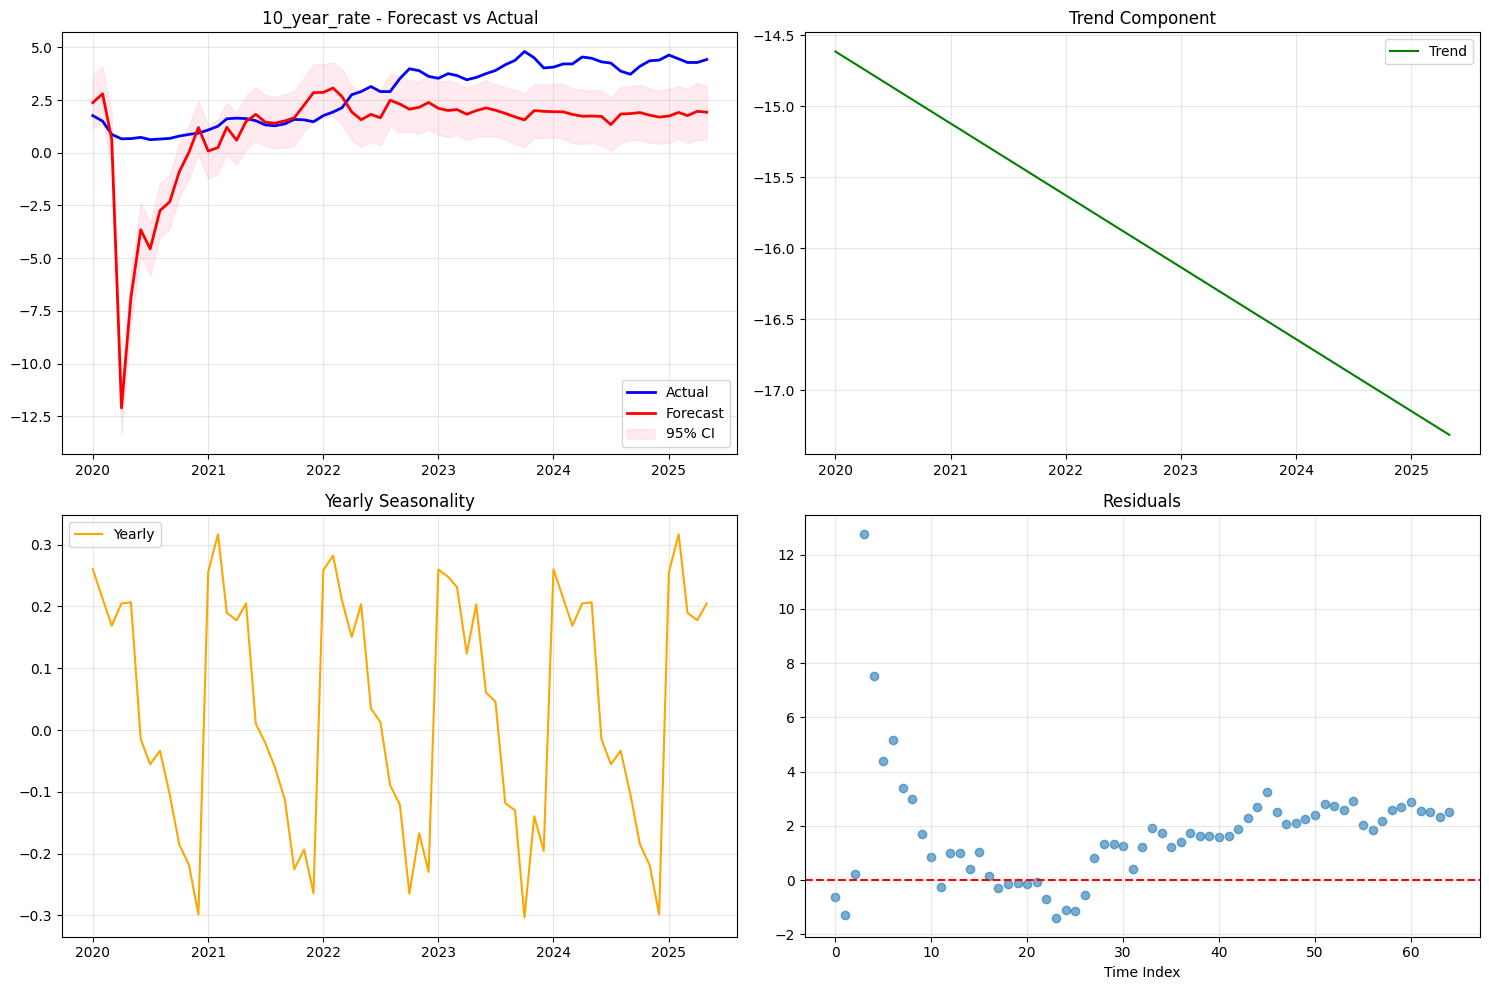

/var/folders/vx/lz_s92194473v0lcw_034qq40000gn/T/ipykernel_65200/3898925279.py:108: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_exog[col] = train_exog[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/var/folders/vx/lz_s92194473v0lcw_034qq40000gn/T/ipykernel_65200/3898925279.py:109: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_exog[col] = test_exog[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
20:30:11 - cmdstanpy - INFO - Chain [1] start processing
20:30:11 - cmdstanpy - INFO - Chain [1] done processing



Prophet Forecasting: share_price
✓ Clean data: 635 train, 65 test rows
Processing 35 potential exogenous features...
✓ Added 34 valid exogenous regressors
✓ After merging: 635 train, 65 test rows
🔄 Fitting Prophet model...
✓ Forecasting 65 periods...
📊 Results:
   MAE: 0.3555
   RMSE: 0.3876
   MAPE: 5.23%
✓ Forecast has variation (std: 0.5202)


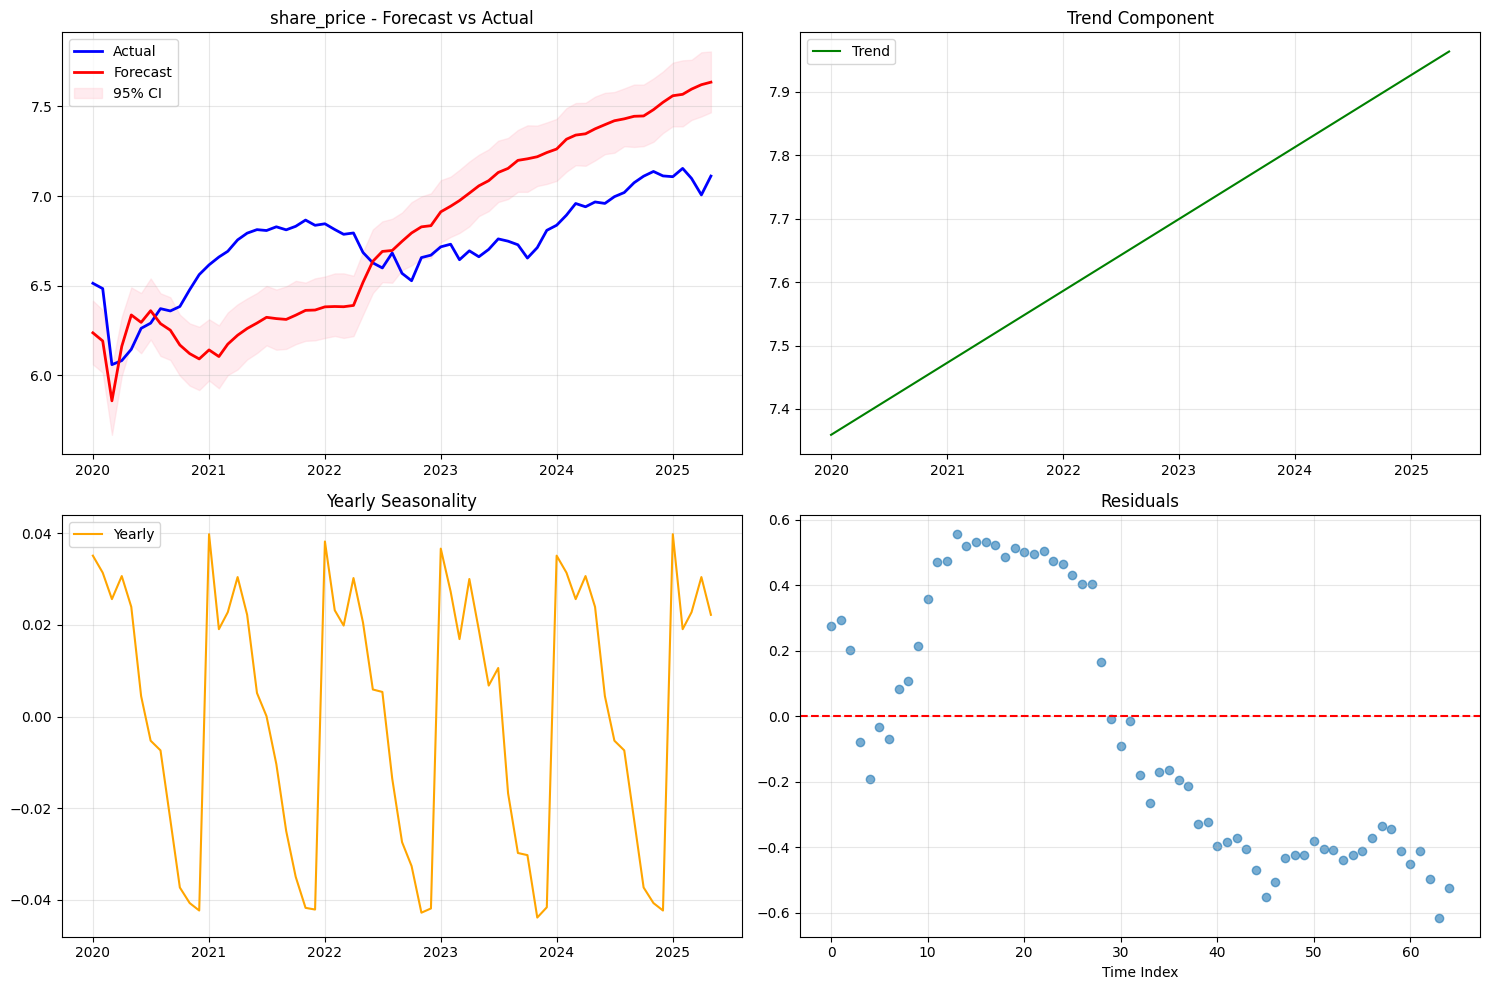

/var/folders/vx/lz_s92194473v0lcw_034qq40000gn/T/ipykernel_65200/3898925279.py:108: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_exog[col] = train_exog[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/var/folders/vx/lz_s92194473v0lcw_034qq40000gn/T/ipykernel_65200/3898925279.py:109: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_exog[col] = test_exog[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
20:30:12 - cmdstanpy - INFO - Chain [1] start processing



Prophet Forecasting: unemployment_rate
✓ Clean data: 635 train, 65 test rows
Processing 35 potential exogenous features...
✓ Added 34 valid exogenous regressors
✓ After merging: 635 train, 65 test rows
🔄 Fitting Prophet model...


20:30:12 - cmdstanpy - INFO - Chain [1] done processing


✓ Forecasting 65 periods...
📊 Results:
   MAE: 0.1742
   RMSE: 0.2939
   MAPE: 3.09%
✓ Forecast has variation (std: 2.0870)


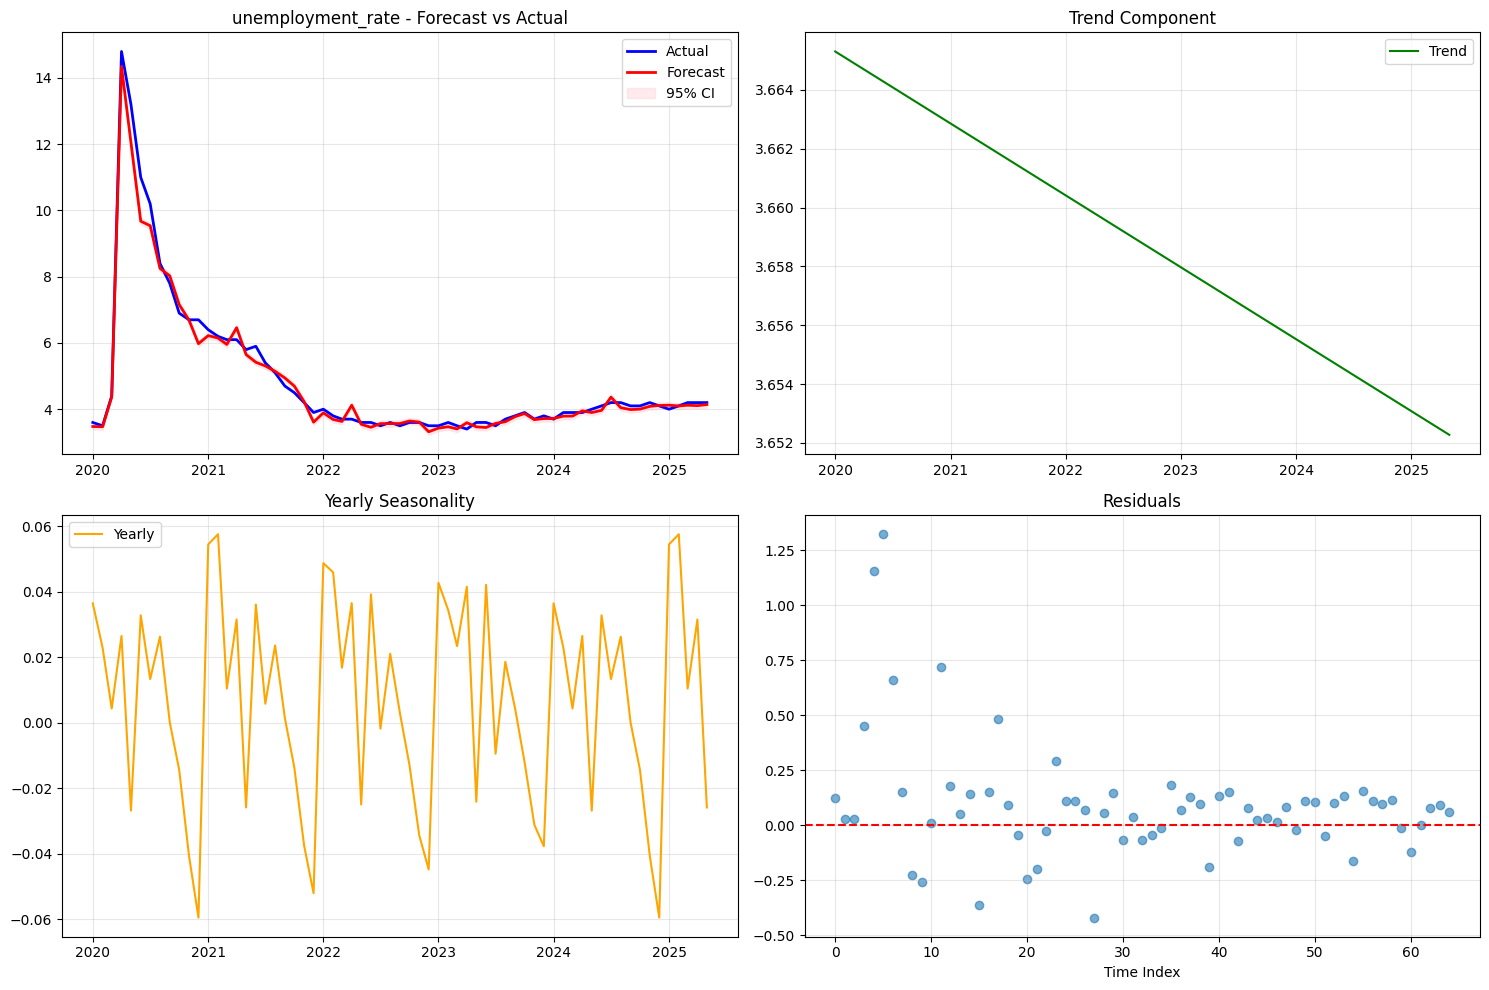

/var/folders/vx/lz_s92194473v0lcw_034qq40000gn/T/ipykernel_65200/3898925279.py:108: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_exog[col] = train_exog[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/var/folders/vx/lz_s92194473v0lcw_034qq40000gn/T/ipykernel_65200/3898925279.py:109: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_exog[col] = test_exog[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
20:30:12 - cmdstanpy - INFO - Chain [1] start processing



Prophet Forecasting: PPI
✓ Clean data: 635 train, 65 test rows
Processing 35 potential exogenous features...
✓ Added 34 valid exogenous regressors
✓ After merging: 635 train, 65 test rows
🔄 Fitting Prophet model...


20:30:12 - cmdstanpy - INFO - Chain [1] done processing


✓ Forecasting 65 periods...
📊 Results:
   MAE: 9.6556
   RMSE: 12.6239
   MAPE: 2.03%
✓ Forecast has variation (std: 97.4813)


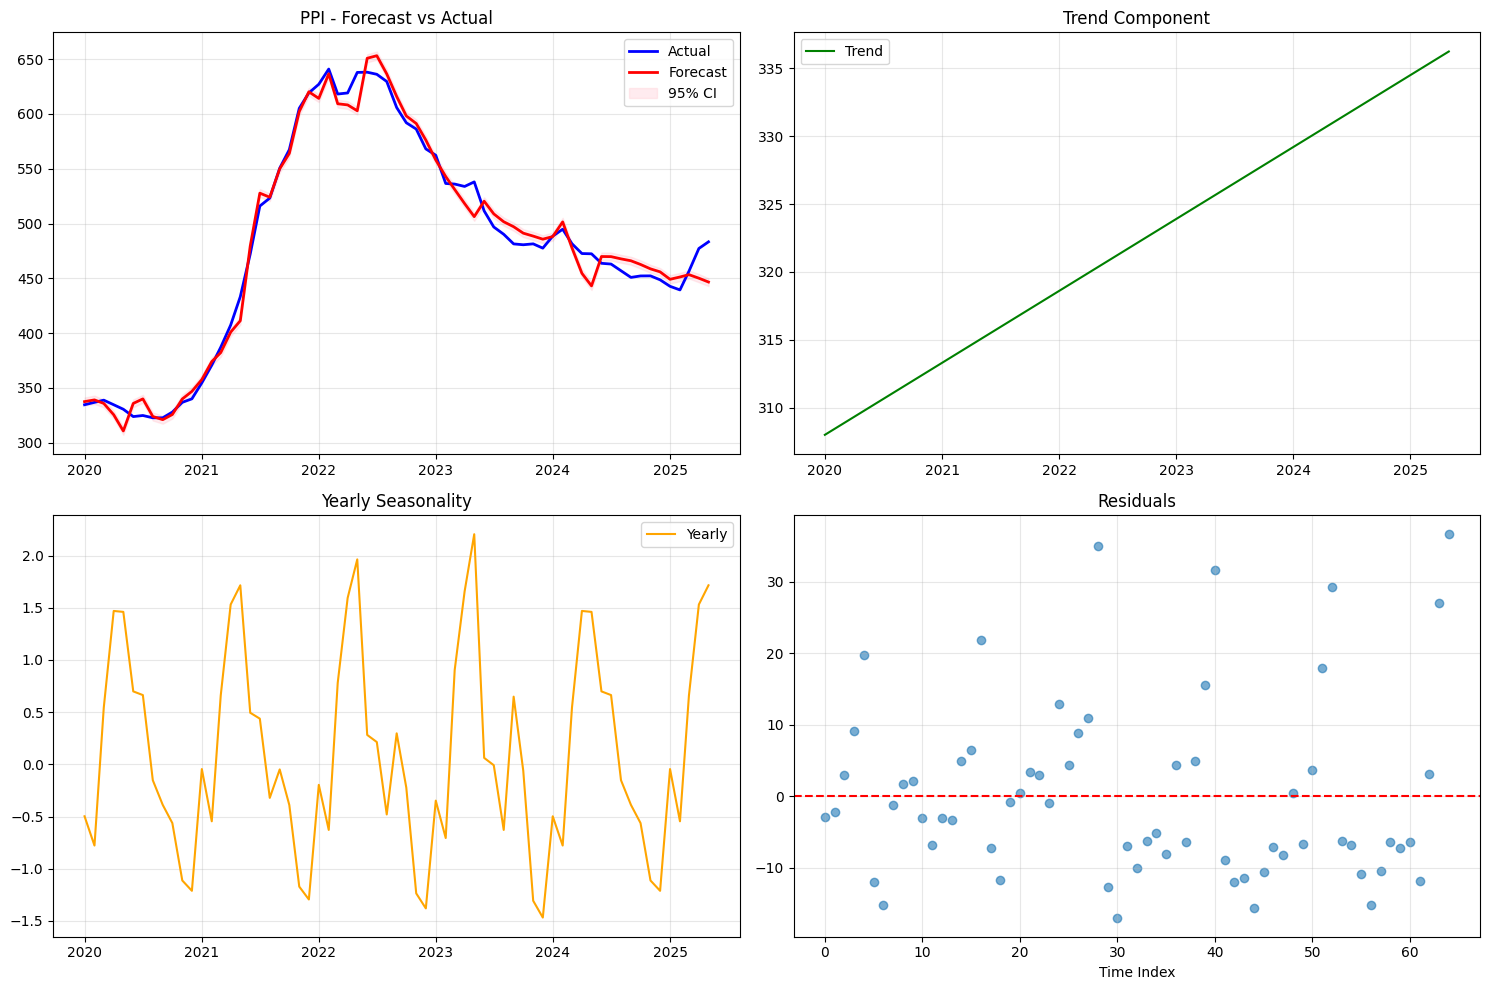

/var/folders/vx/lz_s92194473v0lcw_034qq40000gn/T/ipykernel_65200/3898925279.py:108: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_exog[col] = train_exog[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/var/folders/vx/lz_s92194473v0lcw_034qq40000gn/T/ipykernel_65200/3898925279.py:109: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_exog[col] = test_exog[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
20:30:13 - cmdstanpy - INFO - Chain [1] start processing



Prophet Forecasting: OECD_CLI_index
✓ Clean data: 635 train, 65 test rows
Processing 35 potential exogenous features...
✓ Added 34 valid exogenous regressors
✓ After merging: 635 train, 65 test rows
🔄 Fitting Prophet model...


20:30:13 - cmdstanpy - INFO - Chain [1] done processing


✓ Forecasting 65 periods...
📊 Results:
   MAE: 1.8099
   RMSE: 2.4446
   MAPE: 1.84%
✓ Forecast has variation (std: 3.3445)


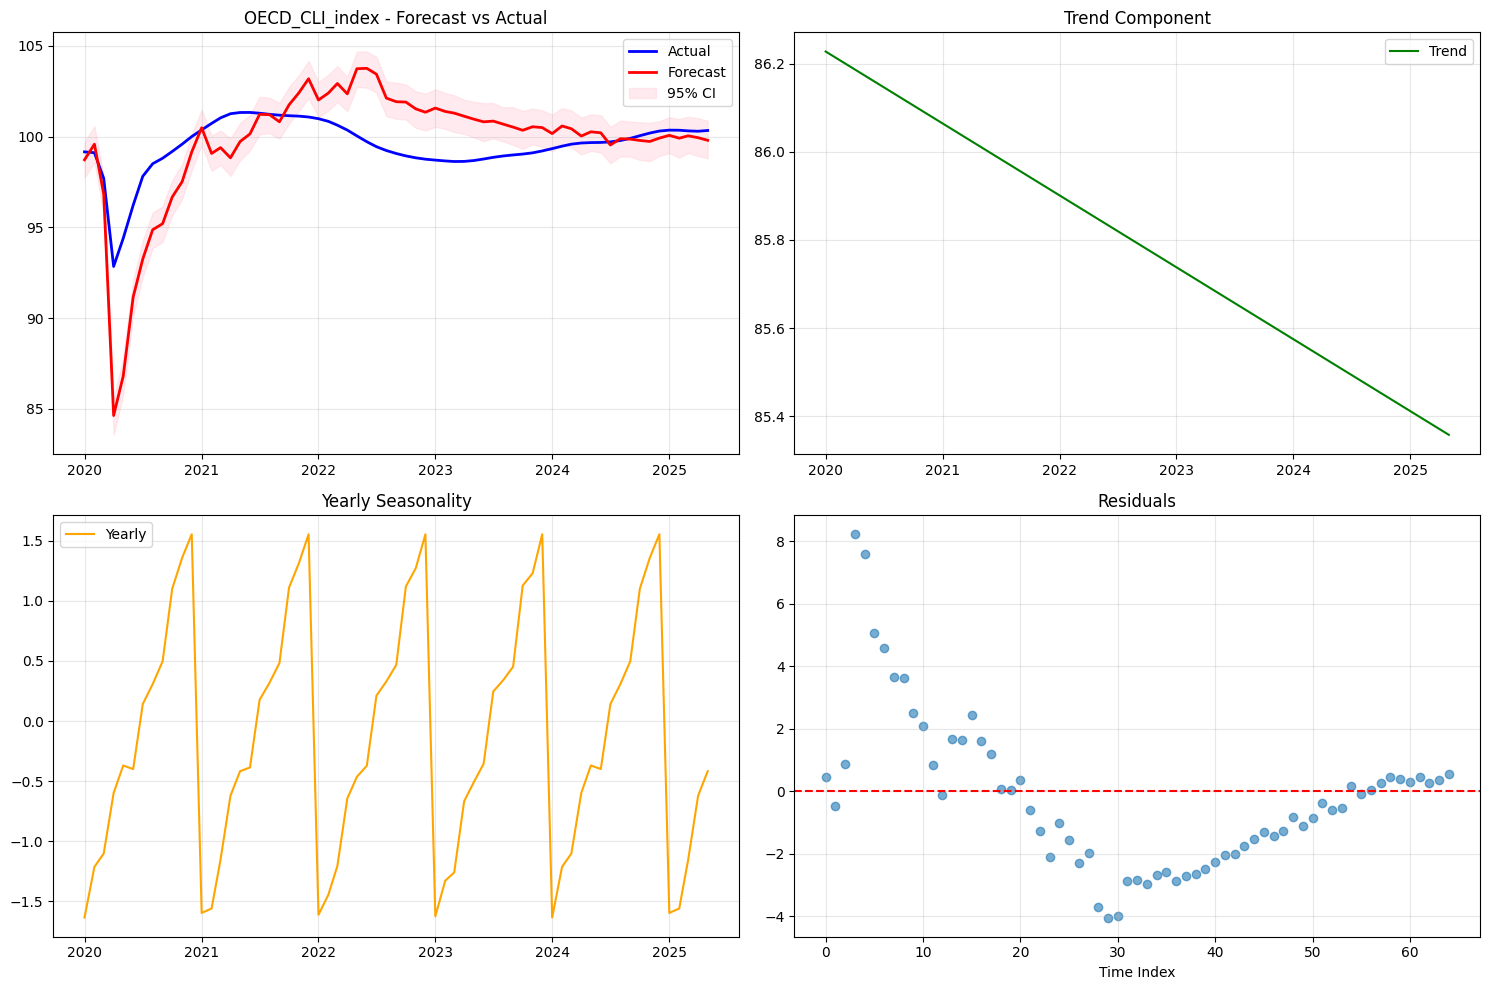

/var/folders/vx/lz_s92194473v0lcw_034qq40000gn/T/ipykernel_65200/3898925279.py:108: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_exog[col] = train_exog[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/var/folders/vx/lz_s92194473v0lcw_034qq40000gn/T/ipykernel_65200/3898925279.py:109: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_exog[col] = test_exog[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
20:30:14 - cmdstanpy - INFO - Chain [1] start processing
20:30:14 - cmdstanpy - INFO - Chain [1] done processing



Prophet Forecasting: CSI_index
✓ Clean data: 635 train, 65 test rows
Processing 35 potential exogenous features...
✓ Added 34 valid exogenous regressors
✓ After merging: 635 train, 65 test rows
🔄 Fitting Prophet model...
✓ Forecasting 65 periods...
📊 Results:
   MAE: 16.8757
   RMSE: 19.9376
   MAPE: 25.88%
✓ Forecast has variation (std: 13.3976)


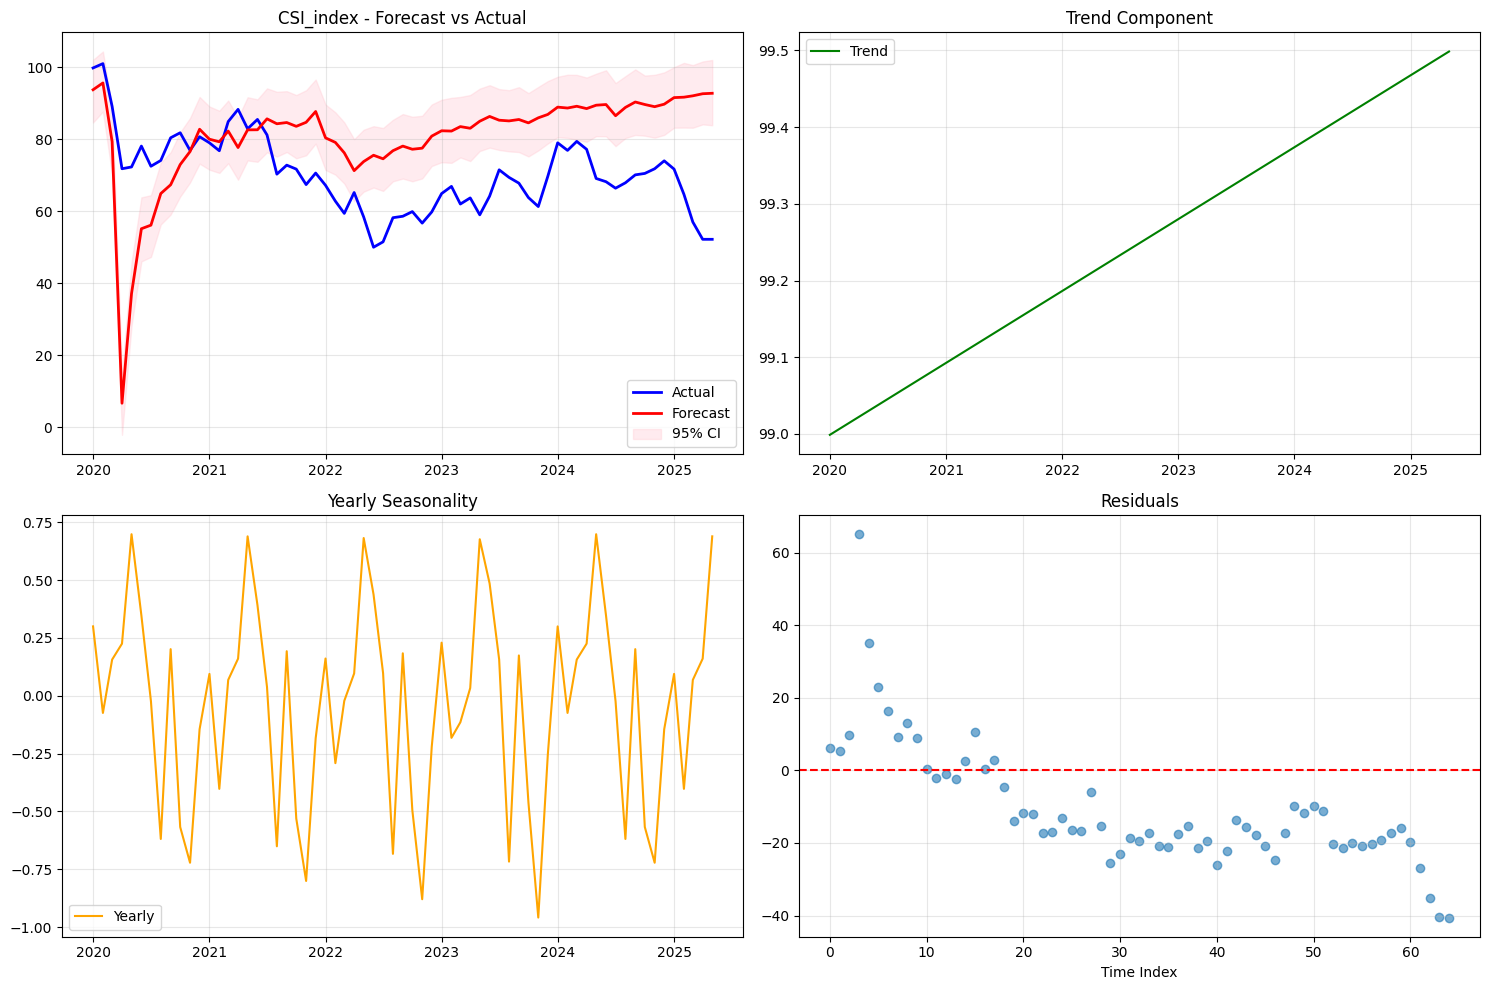

/var/folders/vx/lz_s92194473v0lcw_034qq40000gn/T/ipykernel_65200/3898925279.py:108: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_exog[col] = train_exog[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/var/folders/vx/lz_s92194473v0lcw_034qq40000gn/T/ipykernel_65200/3898925279.py:109: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_exog[col] = test_exog[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
20:30:14 - cmdstanpy - INFO - Chain [1] start processing



Prophet Forecasting: gdp_per_capita
✓ Clean data: 635 train, 64 test rows
Processing 35 potential exogenous features...
✓ Added 34 valid exogenous regressors
✓ After merging: 635 train, 64 test rows
🔄 Fitting Prophet model...


20:30:15 - cmdstanpy - INFO - Chain [1] done processing


✓ Forecasting 64 periods...
📊 Results:
   MAE: 2709.4918
   RMSE: 3177.5369
   MAPE: 4.05%
✓ Forecast has variation (std: 1647.2310)


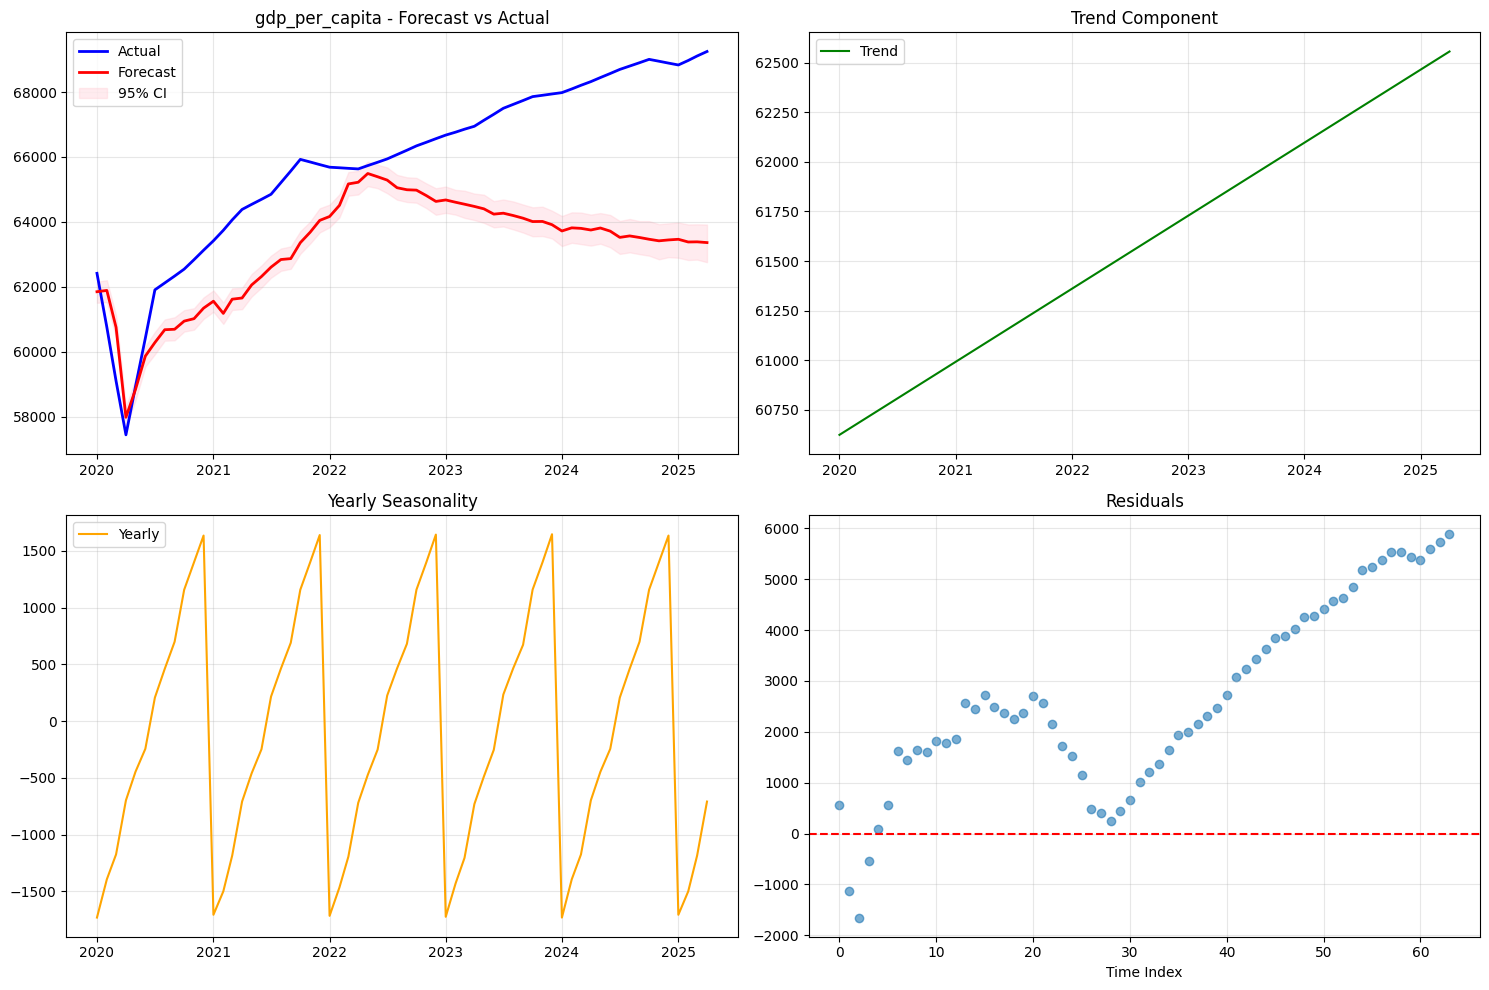


📈 PIPELINE SUMMARY
✅ Successful: 12
❌ Failed: 0
1_year_rate => MAE: 4.4816, RMSE: 5.2782, MAPE: 1101.70%
3_months_rate => MAE: 2.7757, RMSE: 3.8402, MAPE: 1108.68%
6_months_rate => MAE: 2.5695, RMSE: 3.5732, MAPE: 800.63%
CPI => MAE: 0.5073, RMSE: 0.6254, MAPE: 0.18%
INDPRO => MAE: 0.2560, RMSE: 0.3503, MAPE: 0.26%
10_year_rate => MAE: 1.9674, RMSE: 2.6989, MAPE: 130.40%
share_price => MAE: 0.3555, RMSE: 0.3876, MAPE: 5.23%
unemployment_rate => MAE: 0.1742, RMSE: 0.2939, MAPE: 3.09%
PPI => MAE: 9.6556, RMSE: 12.6239, MAPE: 2.03%
OECD_CLI_index => MAE: 1.8099, RMSE: 2.4446, MAPE: 1.84%
CSI_index => MAE: 16.8757, RMSE: 19.9376, MAPE: 25.88%
gdp_per_capita => MAE: 2709.4918, RMSE: 3177.5369, MAPE: 4.05%


In [5]:
# Assuming df contains 'date', financial indicators, and exogenous features
results = run_prophet_pipeline_fixed(dim_reduced_df, financial_indicators, include_exog=True, plot_results=True)

# Check performance metrics
for indicator, metrics in results.items():
    print(f"{indicator} => MAE: {metrics['mae']:.4f}, RMSE: {metrics['rmse']:.4f}, MAPE: {metrics['mape']:.2f}%")
